![](https://upload.wikimedia.org/wikipedia/commons/8/82/Komoot-logo-type.svg)

# Komoot network analysis 
Questo è il progetto di Riccardo Carissimi per il corso di Social Media Mining @ Unimi.
In questo notebook analizzeremo la rete di Komoot (o almeno ci proveremo).

# Scraping
## 1. Lo scraper

In [48]:
from bs4 import BeautifulSoup
import time
import networkx as nx
import pandas as pd
import persistqueue
import requests

Andiamo a definire il primo seed. È un utente in cui sono incappato con un numero accettabile di amici.

In [3]:
seed_user_id = "813735907910"

Ora definiamo la funzione che ci permetterà di avere la lista di following per un utente. Purtroppo dobbiamo crearci un piccolo scraper, perchè questa funzionalità non è prevista nelle API.

In [7]:
def get_user_followings(user_id):
    #Imposto l'endpoint
    url = f'https://www.komoot.com/it-it/user/{user_id}/following'
    
    #Inizializzo il webdriver di Selenium
    driver = webdriver.Chrome()
    driver.get(url)
    
    #Inizializzo il set con i following e lo scroll-delay
    links = set()
    scroll_delay = 2
    last_height = driver.execute_script("return document.body.scrollHeight")
    counter = 0

    old_users = set()

    while True:

        users = driver.find_elements(By.CSS_SELECTOR, 'a.c-link.c-link--inherit.tw-font-bold')
        users_dedupe = set(users) - set(old_users)

        for user in users_dedupe:
            links.add(user.get_attribute('href').split('/')[-1])

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_delay)
        new_height = driver.execute_script("return document.body.scrollHeight")

        old_users = users

        if new_height == last_height:
            break
        last_height = new_height

    driver.quit()
    return links

In [23]:
get_user_followings(seed_user_id)

{'1024020220028',
 '1136281104054',
 '1189125754755',
 '1382684320656',
 '2137732485327',
 '2262262155625',
 '384449563507',
 '444811548445',
 '505500745409',
 '506348671596',
 '658070566843',
 '660023066061',
 '695866282288',
 '774010743877',
 '962009552239',
 'betty',
 'gmbn',
 'oesterreichsgroesstebikeregion'}

Ora modifico la funzione per fare in modo che si possano ottenere sia i follower che i following

In [204]:
def get_user_follow(user_id, relation):
    #Imposto l'endpoint
    url = f'https://www.komoot.com/it-it/user/{user_id}/{relation}'
    
    #Inizializzo il webdriver di Selenium
    driver = webdriver.Chrome()
    driver.get(url)
    
    #Inizializzo il set con i following e lo scroll-delay
    links = set()
    scroll_delay = 1.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    counter = 0

    old_users = set()

    while True:

        users = driver.find_elements(By.CSS_SELECTOR, 'a.c-link.c-link--inherit.tw-font-bold')
        users_dedupe = set(users) - set(old_users)

        for user in users_dedupe:
            links.add(user.get_attribute('href').split('/')[-1])

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_delay)
        new_height = driver.execute_script("return document.body.scrollHeight")

        old_users = users

        if new_height == last_height:
            break
        last_height = new_height

    driver.quit()
    return links

In [25]:
get_user_follow(seed_user_id, "following")

{'1024020220028',
 '1136281104054',
 '1189125754755',
 '1382684320656',
 '2137732485327',
 '2262262155625',
 '384449563507',
 '444811548445',
 '505500745409',
 '506348671596',
 '658070566843',
 '660023066061',
 '695866282288',
 '774010743877',
 '962009552239',
 'betty',
 'gmbn',
 'oesterreichsgroesstebikeregion'}

In [26]:
get_user_follow(seed_user_id, "followers")

{'1136281104054',
 '1189125754755',
 '1382684320656',
 '1660920328668',
 '1873906957124',
 '2137732485327',
 '658070566843',
 '660023066061'}

Siamo sulla buona strada. Ora dobbiamo automatizzare lo scraper, per ottenere il numero maggiore possibile di nodi.

## 2. Lo scraping improvvisato

In [37]:
#Questa funzione visiterà tutti i nodi a partire dal seed, secondo un threshold impostato
def visit():
    queue = [(seed_user_id,0)]
    visited = {seed_user_id}
    threshold = 1
    
    while queue:
        n, l = queue.pop(0)
        if l + 1 <= threshold:
            for neigh in get_user_follow(n, "following"):
                if neigh not in visited:
                    visited.add(neigh)
                    queue.append((neigh,l+1))
                yield (n,neigh)

In [38]:
g = nx.DiGraph()
for a,b in visit():
    g.add_edge(a,b)

Stampiamo qualche proprietà base e proviamo a stamparlo, per assicurarci di aver ottenuto qualcosa di vagamente corretto

In [29]:
g.order(), g.size()

(19, 18)

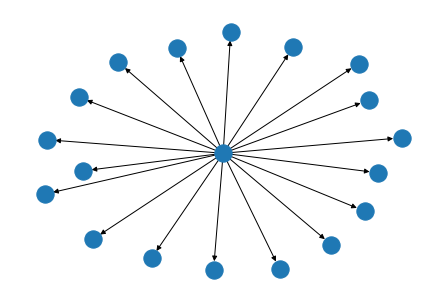

In [30]:
nx.draw(g, nx.spring_layout(g))

Ora esportiamolo e guardiamolo su Gephi

In [31]:
nx.write_graphml(g,path="test.graphml")

## 3. Lo scraping persistente

Mi sono reso conto che non è veramente necessario usare Selenium. Proviamo a usare le API.

In [8]:
def get_user_follow(user_id, session=None):
    #Imposto l'endpoint
    if session == None:
        session = requests.Session()
    
    params = {
        'username': 695738537576,
        'relation_to_follow': 'FOLLOW',
        'relation_to_friend': 'FRIEND',
        'page': 0,
        'limit': 100,
        'hl': 'it'
    }
    
    url = f'https://www.komoot.com/api/v007/users/{user_id}/relating_users/'    
    
    followings = set()
    
    while True:
        resp = session.get(url=url, params=params)
        data = resp.json()
        
        if resp.status_code != 200:
            raise Exception("Response code " + str(resp.status_code)) 
        
        if data['page']['totalElements'] == 0:
            return set()
        
        for user in data['_embedded']['items']:
            followings.add(user['username'])
        
        if data['page']['totalPages'] == data['page']['number']+1:
            break
        params['page'] = params['page'] + 1
        
    return followings

In [9]:
friends = get_user_follow('betty')
len(friends)

373

In [39]:
import time

class KomootSurferPersistent():               
    def __init__(self, seed, nodes=list(), threshold=2, limit=5000, reset=True):
        self.queue = persistqueue.Queue("dbs/surfer.queue")
        self.threshold = threshold
        self.limit = limit
        if reset:
            self.empty_queue()
            self.visited = set()
            self.queue.put((seed, 0))
        else:
            for node in nodes():
                self.visited.put(node)

    def empty_queue(self):
        while not self.queue.empty():
            self.queue.get()

    def _get_following(self, user_id):
        follow = None
        while follow is None:
            try:
                follow = get_user_follow(user_id)
            except:
                time.sleep(5)
        return follow
    
    def visit(self):
        c = 0
        while self.queue.qsize() > 0:
            if c >= self.limit:
                break
            
            n, l = self.queue.get()
            
            if l + 1 <= self.threshold:
                if c%100 == 0:
                    print(c)
                c = c+1
                for neigh in self._get_following(n):
                    if not neigh in self.visited:
                        self.visited.add(neigh)
                        self.queue.put((neigh,l+1))
                    yield (n,neigh)

In [40]:
g = nx.DiGraph()

In [41]:
surfer = KomootSurferPersistent(seed_user_id, threshold=10, limit=100000, reset=True)

In [ ]:
#DAI CHE CE LA FACCIAMO
for a,b in surfer.visit():
    g.add_edge(a,b)

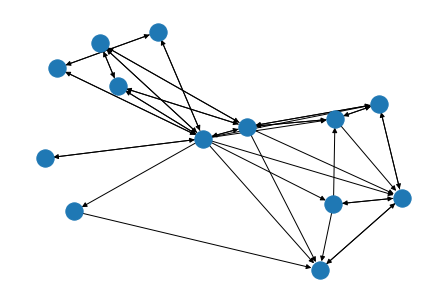

In [89]:
nx.draw(g, nx.spring_layout(g))

In [43]:
g.order(), g.size()

(646427, 2050406)

In [44]:
nx.write_graphml(g,path="graphs/komoot-network-100000.graphml")

## 4. Togliamo le foglie

Per prima cosa togliamo le foglie dal nostro grafo

In [7]:
g = nx.read_graphml("graphs/komoot-network.graphml")

In [58]:
g.order(), g.size()

(1595, 2085)

In [48]:
leafs = [x for x in g.nodes() if g.out_degree(x)==0]
g.remove_nodes_from(leafs)

In [32]:
g.order(), g.size()

(7755, 133901)

A quanto pare va eseguita più volte, sigh :'(

In [33]:
leafs = [x for x in g.nodes() if g.out_degree(x)==0]
leafs

[]

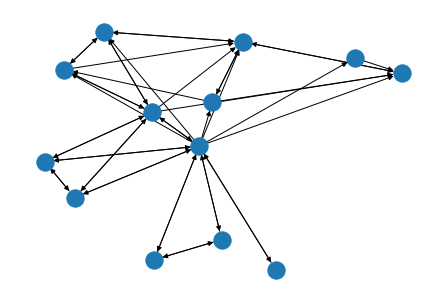

In [22]:
nx.draw(g, nx.spring_layout(g))

In [34]:
nx.write_graphml(g,path="graphs/komoot-network-10000-wo-leafs.graphml")

## 5. Otteniamo altre informazioni sugli utenti

Per prima cosa impostiamo la funzione per trovare il paese date le coordinate. Successivamente vogliamo ottenere la lista degli ultimi 5 tour e dalla moda dei valori stimare due informazioni: il paese dell'utente e il suo sport preferito.

In [7]:
g = nx.read_graphml("graphs/komoot-network-100000-wo-leafs.graphml")

In [8]:
import countries

#sudo apt install libdgal-dev gdal-bin

def get_country(lat, long):
    cc = countries.CountryChecker('maps/TM_WORLD_BORDERS-0.3.shp')
    try:
        iso = cc.getCountry(countries.Point(lat, long)).iso
    except:
        iso = "Unknown"
    return iso

In [9]:
def get_user_tours_info(user_id, session=None):
    url = f'https://www.komoot.com/api/v007/users/{user_id}/tours/'
    
    if session == None:
        session = requests.Session()
    
    params = {
        'sort_field': 'date',
        'sort_direction': 'desc',
        'status': 'public',
        'hl': 'it',
        'page': 0,
        'limit': 5,
    }
    
    countries = list()
    sport_type = list()
    
    try:
        resp = session.get(url=url, params=params)
    except:
        sleep(5)
        resp = session.get(url=url, params=params)
        
    data = resp.json()

    if resp.status_code != 200:
        raise Exception("Response code " + str(resp.status_code)) 

    if data['page']['totalElements'] == 0:
        return 'Unknown', 'Unknown'
    
    try:
        for tour in data['_embedded']['tours']:
            countries.append(get_country(tour['start_point']['lat'], tour['start_point']['lng']))
            sport_type.append(tour['sport'])
    except:
        return "Unknown", "Unknown"
    
    return max(set(countries), key=countries.count), max(set(sport_type), key=sport_type.count)

In [60]:
get_user_tours_info(seed_user_id)

('GB', 'racebike')

Infine, otteniamo il numero di KM totali dalla pagina profilo, e anche il nome

In [10]:
def get_user_info(user_id):
    #Imposto l'endpoint
    url = f"https://www.komoot.com/it-it/user/{user_id}"
    
    #Creo una richiesta con BeautifulSoup e filtro il risultato
    try:
        resp = requests.get(url=url, params={})
    except:
        sleep(10)
        resp = requests.get(url=url, params={})
        
    soup = BeautifulSoup(resp.content)
    
    temp_km = soup.find_all("p", {"class": "css-1sqi9d7"})
    km = 0
    if len(temp_km) > 0 and temp_km[0].text[-2:] == "km":
        km = int(float(temp_km[0].text[:-3].replace('.', '').replace(',', '.')))
        
    temp_name = soup.find_all("a", {"class": "c-link c-link--inherit"})
    name = "Unknown"
    if len(temp_name) > 0:
        name = temp_name[0].text
        
    return name, km
    

In [61]:
get_user_info(seed_user_id)

('James', 663)

## 6. Aggiungiamo queste informazioni a tutti i nodi

In [71]:
class KomootCuriosonePersistent():
    def __init__(self, graph, nodes=None, reset=True):
        self.queue = persistqueue.Queue("dbs/curiosone.queue")
        if reset:
            self.empty_queue()
            if nodes == None:
                nodes == list(graph.nodes())
            for node in nodes:
                self.queue.put(node)
            self.queue.put(0)
            print(len(nodes))

    def empty_queue(self):
        while not self.queue.empty():
            self.queue.get()

    def get_next(self):
        return self.queue.get()

In [ ]:
nodelist = list(g.nodes())
nodelist.sort()
nodelist = nodelist[0:5000]
nodelist

In [78]:
curiosone = KomootCuriosonePersistent(g, reset=True, nodes=nodelist)

5000


Ora vogliamo prendere un utente alla volta e aggiungere le informazioni al grafo

In [ ]:
c = 0
while True:
    #Stampiamo una sorta di stato
    if c%100 == 0:
        print(c)
    c = c + 1
    
    #Prendiamo il prossimo utente
    user_id = curiosone.get_next()
    
    #Se è l'ultimo elemento finiamo
    if user_id == 0:
        break
        
    #Otteniamo tutte le info per l'utente e le inseriamo in un dizionario apposito
    g.nodes[user_id]["name"], g.nodes[user_id]["km"] = get_user_info(user_id)
    g.nodes[user_id]["country"], g.nodes[user_id]["sport"] = get_user_tours_info(user_id)

E infine salviamo il grafo!

In [33]:
nx.write_graphml(g,path="graphs/komoot-network-attributes.graphml")

## Facciamolo multithread

In [11]:
class KomootCuriosonePersistent():
    def __init__(self, graph, nodes=None, reset=True, number=0):
        self.queue = persistqueue.Queue(f"dbs/curiosone-{number}.queue")
        if reset:
            self.empty_queue()
            if nodes == None:
                nodes == list(graph.nodes())
            for node in nodes:
                self.queue.put(node)
            self.queue.put(0)

    def empty_queue(self):
        while not self.queue.empty():
            self.queue.get()

    def get_next(self):
        return self.queue.get()

In [12]:
def bounded_infos(lock, graph, start, end, nodelist):
    if nodelist == None:
        nodelist = list(graph.nodes())
    nodelist.sort()
    nodelist = nodelist[start:end]
    nodelist.append(0)
    
    curiosone = KomootCuriosonePersistent(graph, reset=True, nodes=nodelist, number=start)
    
    #c = 0
    while True:
        #Stampiamo una sorta di stato
        #if c%10 == 0 and start == 0:
        #    print(c)
        #c = c + 1

        #Prendiamo il prossimo utente
        user_id = curiosone.get_next()

        #Se è l'ultimo elemento finiamo
        if user_id == 0:
            break

        #Otteniamo tutte le info per l'utente e le inseriamo in un dizionario apposito
        name, km = get_user_info(user_id)
        country, sport = get_user_tours_info(user_id)
        
        lock.acquire()
        graph.nodes[user_id]["name"], graph.nodes[user_id]["km"], graph.nodes[user_id]["country"], graph.nodes[user_id]["sport"] = name, km, country, sport
        lock.release()

In [ ]:
from threading import Thread, Lock
from time import sleep

#Second run
rimanenti = []
for n in list(g.nodes):
    try:
        g.nodes[n]["name"]
    except:
        rimanenti.append(n)

procs = []
lock = Lock()

threads = 40
#nodes = g.nodes()
nodes = rimanenti
step = int(len(nodes)/threads)
print(step)
for i in range(threads-1):
    print(f"Thread Started - Range [{i*step}-{(i+1)*step}]")
    p = Thread(target=bounded_infos, args=(lock, g,i*step, (i+1)*step, nodes))
    procs.append(p)
    p.start()

print(f"Thread Started - Range [{(i+1)*step}-{len(nodes)}]")
p = Thread(target=bounded_infos, args=(lock, g,i*step, (i+1)*step, nodes))
procs.append(p)
p.start()

In [ ]:
# Blocca l'esecuzione finchè i processi non sono terminati   
for t in procs:
    #t.join()
    print(t.ident)

print("Done")

In [15]:
len(g.nodes)

74139

In [ ]:
while True:
    rimanenti = []

    for n in list(g.nodes):
        try:
            g.nodes[n]["name"]
        except:
            rimanenti.append(n)
    
    print(f"{len(rimanenti)}, {int((1-len(rimanenti)/len(g.nodes))*100)}%")
    
    if len(rimanenti) == 0:
        break
    
    sleep(300)

In [ ]:
rimanenti = []

for n in list(g.nodes):
    try:
        g.nodes[n]["name"]
    except:
        rimanenti.append(n)
        
curiosone = KomootCuriosonePersistent(g, reset=True, nodes=rimanenti, number=99)

c = 0
while True:
    #Stampiamo una sorta di stato
    if c%10 == 0:
        print(c)
    c = c + 1

    #Prendiamo il prossimo utente
    user_id = curiosone.get_next()

    #Se è l'ultimo elemento finiamo
    if user_id == 0:
        break

    #Otteniamo tutte le info per l'utente e le inseriamo in un dizionario apposito
    name, km = get_user_info(user_id)
    country, sport = get_user_tours_info(user_id)

    g.nodes[user_id]["name"], g.nodes[user_id]["km"], g.nodes[user_id]["country"], g.nodes[user_id]["sport"] = name, km, country, sport

In [68]:
nx.write_graphml(g,path="graphs/komoot-network-100000-attributes.graphml")

# Analisi

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Per prima cosa cominciamo col caricare il grafo e avedere come è bello

![](gephi/komoot-countries.png)

In [2]:
g = nx.read_graphml("graphs/komoot-network-100000-attributes.graphml")

Incominciamo a stampare un paio di info sul grafo

In [5]:
print(f"Numero di nodi: {g.order()}\nNumero di archi: {g.size()}")
print(g)

Numero di nodi: 74139
Numero di archi: 1113417
DiGraph with 74139 nodes and 1113417 edges


In [6]:
print(f'Density: {nx.density(g)}')

Density: 0.00020256772846016368


Ora stampiamo l'utente con massimo in degree e out degree

In [7]:
indegree = dict(g.in_degree())
indegree = list(reversed(sorted(indegree.items(), key = lambda x: x[1])))
indegree[:10]

[('komoot', 6512),
 ('orbit', 2389),
 ('979759071586', 2384),
 ('878596569070', 2196),
 ('444811548445', 2142),
 ('263147866419', 1998),
 ('576346192897', 1954),
 ('267850388946', 1913),
 ('414835544103', 1902),
 ('910787423285', 1857)]

In [8]:
outdegree = dict(g.out_degree())
outdegree = list(reversed(sorted(outdegree.items(), key = lambda x: x[1])))
outdegree[:10]

[('2207069696217', 6531),
 ('975940150909', 5095),
 ('746991489833', 4174),
 ('1093755911644', 3052),
 ('979759071586', 2532),
 ('169172928726', 2498),
 ('878596569070', 2234),
 ('1045038351715', 2103),
 ('99084998900', 1969),
 ('910787423285', 1932)]

Ora stampiamo informazioni su indegree medio e outdegree medio

In [9]:
degree_list =list(dict(g.in_degree()).values())
print(f'Grado medio: {np.mean(degree_list)}')
print(f'Standard deviation: {np.std(degree_list)}')
print(f'Median: {np.median(degree_list)}')
print(f'Min: {np.min(degree_list)}')
print(f'Max: {np.max(degree_list)}')

Grado medio: 15.017966252579614
Standard deviation: 67.15731144375731
Median: 3.0
Min: 1
Max: 6512


In [10]:
degree_list =list(dict(g.out_degree()).values())
print(f'Grado medio: {np.mean(degree_list)}')
print(f'Standard deviation: {np.std(degree_list)}')
print(f'Median: {np.median(degree_list)}')
print(f'Min: {np.min(degree_list)}')
print(f'Max: {np.max(degree_list)}')

Grado medio: 15.017966252579614
Standard deviation: 60.01526038966208
Median: 4.0
Min: 1
Max: 6531


Ora calcoliamo la PDF dell'indegree

Text(0, 0.5, 'P(X=x)')

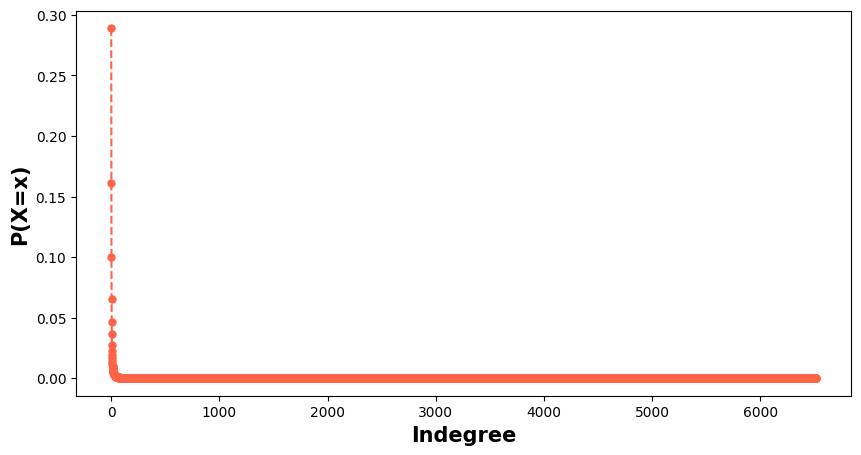

In [28]:
degree_list =list(dict(g.in_degree()).values())
np.arange(min(degree_list),max(degree_list)+1)
count,bins = np.histogram(degree_list, bins=np.arange(min(degree_list),max(degree_list)+2))

pdf = count / g.order()

fig = plt.figure(figsize=(10,5)) 
plt.plot(bins[:-1],pdf, color='tomato',marker='o', linestyle='--', ms=5)
plt.xlabel('Indegree',size=15, weight = 'bold')
plt.ylabel('P(X=x)',size=15, weight = 'bold')

Text(0, 0.5, 'P(X=x)')

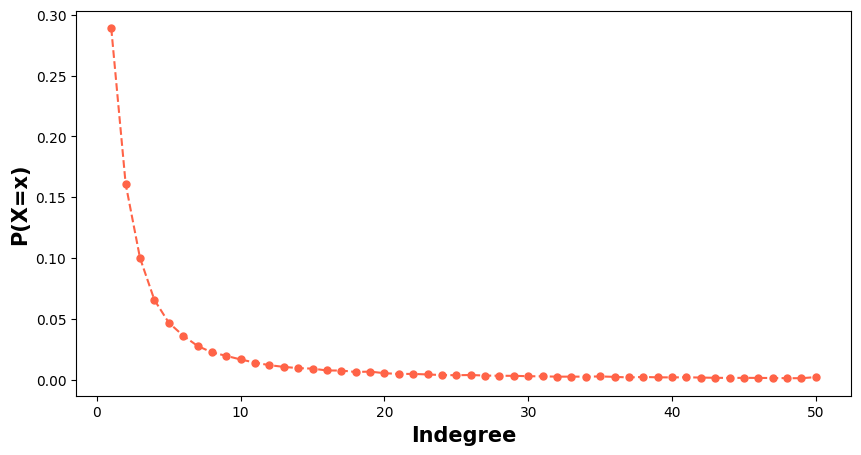

In [29]:
count,bins = np.histogram(degree_list, bins=np.arange(min(degree_list),50+2))

pdf = count / g.order()

fig = plt.figure(figsize=(10,5)) 
plt.plot(bins[:-1],pdf, color='tomato',marker='o', linestyle='--', ms=5)
plt.xlabel('Indegree',size=15, weight = 'bold')
plt.ylabel('P(X=x)',size=15, weight = 'bold')

Troviamo i nodi più centrali per ogni centralità

In [3]:
#InDegree Centrality
degree=dict(g.in_degree())
in_degree_centrality = {n: round(c/(g.order()-1),4) for n,c in degree.items()}
node_d_centr = list(in_degree_centrality.items())
node_d_centr.sort(key = lambda x: x[1], reverse = True)
node_d_centr[:5]

[('komoot', 0.0878),
 ('orbit', 0.0322),
 ('979759071586', 0.0322),
 ('878596569070', 0.0296),
 ('444811548445', 0.0289)]

In [4]:
#Out Degree Centrality
degree=dict(g.out_degree())
out_degree_centrality = {n: round(c/(g.order()-1),4) for n,c in degree.items()}
node_d_centr = list(out_degree_centrality.items())
node_d_centr.sort(key = lambda x: x[1], reverse = True)
node_d_centr[:5]

[('2207069696217', 0.0881),
 ('975940150909', 0.0687),
 ('746991489833', 0.0563),
 ('1093755911644', 0.0412),
 ('979759071586', 0.0342)]

In [5]:
#Eigenvector cenrality
eigenvector_centrality = nx.eigenvector_centrality(g,200)
node_e_centr = list(eigenvector_centrality.items())
node_e_centr.sort(key = lambda x: x[1], reverse = True)
node_e_centr[:5]

[('komoot', 0.17538982208333062),
 ('910787423285', 0.1411883194106963),
 ('267850388946', 0.12220672337326605),
 ('263147866419', 0.10427739050233055),
 ('1038353740970', 0.10122367556368272)]

Ora disegnamo un bel grafico con la correlazione tra le misure

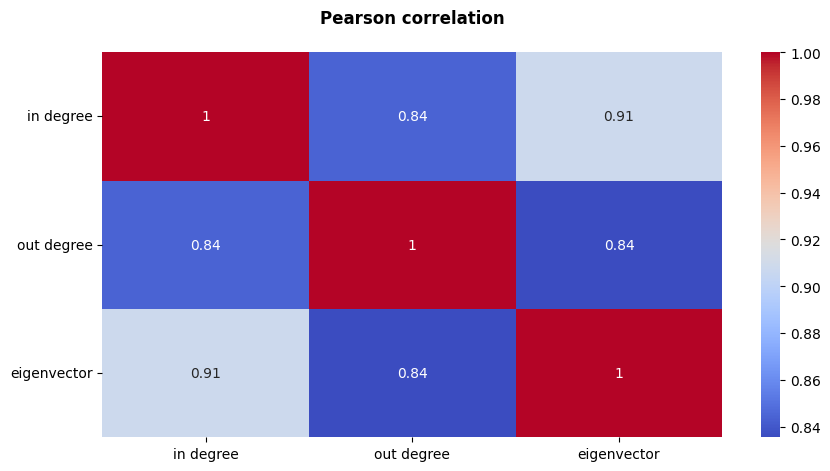

In [6]:
import scipy
import seaborn as sns

all_centr = [in_degree_centrality, out_degree_centrality, eigenvector_centrality]
ranks = [[scipy.stats.weightedtau(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['in degree', 'out degree', 'eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(ranks),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(3)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(3)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()

Ora verifichiamo il numero di componenti connesse, sia deboli che forti

In [43]:
print(nx.is_weakly_connected(g))
print(nx.number_weakly_connected_components(g))

True
1


In [44]:
print(nx.is_strongly_connected(g))
print(nx.number_strongly_connected_components(g))

False
283


In [49]:
largest_cc = max(nx.strongly_connected_components(g), key=len)
len(largest_cc)

73571

Controlliamo la reciprocità

In [52]:
nx.reciprocity(g)

0.4497667989621139

Calcoliamo il coefficiente medio di clustering

In [53]:
nx.average_clustering(g)

0.26648675568487057

Calcoliamo il numero di utenti per ogni paese e per ogni sport

In [248]:
# Calcola il numero di nodi per ogni valore di "country"
country_counts = {}
for node in g.nodes():
    country = g.nodes[node]['country']
    if country in country_counts:
        country_counts[country] += 1
    else:
        country_counts[country] = 1

countries_list = list(reversed(sorted(country_counts.items(), key=lambda item: item[1])))
df = pd.DataFrame(countries_list, columns=['Country', 'Users'])
df['Percent'] = (df['Users'] / df['Users'].sum()) * 100
df[:15]

,Country,Users,Percent
0,DE,31320,42.244972
1,Unknown,12707,17.139427
2,GB,8239,11.112910
3,IT,4286,5.781033
4,ES,4203,5.669081
5,AT,3217,4.339147
6,FR,2207,2.976841
7,NL,1943,2.620753
8,CH,1422,1.918019
9,BE,736,0.992730


In [247]:
# Calcola il numero di nodi per ogni valore di "sport"
sport_counts = {}
for node in g.nodes():
    sport = g.nodes[node]['sport']
    if sport in sport_counts:
        sport_counts[country] += 1
    else:
        sport_counts[country] = 1

sports_list = list(reversed(sorted(country_counts.items(), key=lambda item: item[1])))
df = pd.DataFrame(sports_list, columns=['Sport', 'Users'])
df['Percent'] = (df['Users'] / df['Users'].sum()) * 100
df

,Sport,Users,Percent
0,hike,22896,30.882531
1,touringbicycle,12153,16.392182
2,Unknown,11937,16.100838
3,racebike,10076,13.590688
4,mtb,8425,11.363790
5,mtb_easy,5576,7.521008
6,jogging,1730,2.333455
7,mtb_advanced,388,0.523341
8,other,309,0.416785
9,mountaineering,263,0.354739


Ora proviamo a plottare il numero di Km percorsi con un'istogramma. Prima proviamo col grafico senza limiti, poi selezioniamo solo i valori tra 1 e 5000

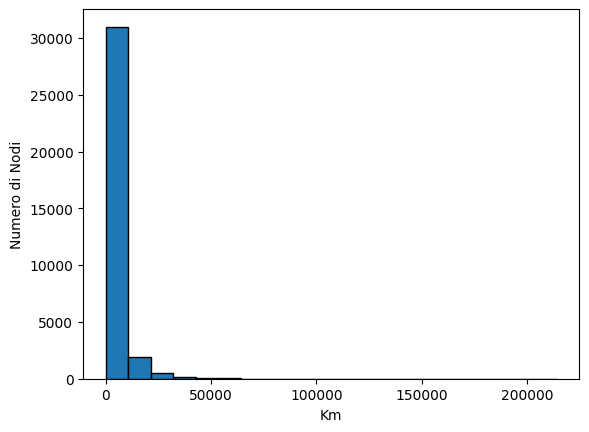

In [115]:
# Ottieni i valori di "km" dei nodi
km_values = [g.nodes[node]['km'] for node in g.nodes() if g.nodes[node]['km'] > 0]

# Specifica il numero di bin per l'istogramma
num_bins = 20

# Crea l'istogramma
plt.hist(km_values, bins=num_bins, edgecolor='black')

# Aggiungi etichette e titolo all'istogramma
plt.xlabel('Km')
plt.ylabel('Numero di Nodi')

# Mostra l'istogramma
plt.show()

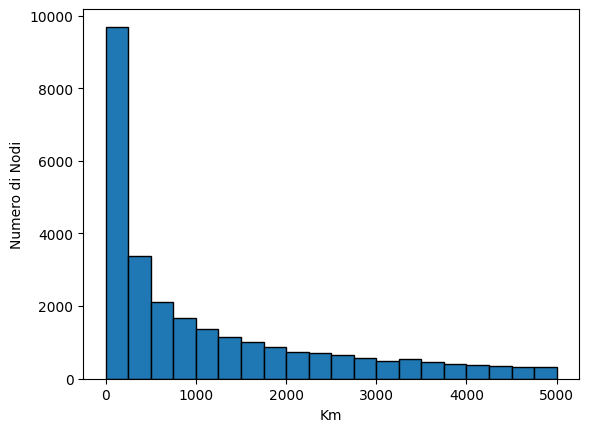

In [116]:
# Ottieni i valori di "km" dei nodi
km_values = [g.nodes[node]['km'] for node in g.nodes() if 1 <= g.nodes[node]['km'] <= 5000]

# Specifica il numero di bin per l'istogramma
num_bins = 20

# Crea l'istogramma
plt.hist(km_values, bins=num_bins, edgecolor='black')

# Aggiungi etichette e titolo all'istogramma
plt.xlabel('Km')
plt.ylabel('Numero di Nodi')

# Mostra l'istogramma
plt.show()

## Correlazione tra paese e sport

Ora creiamo un'heatmap per capire se c'è correlazione tra tra paesi e km

In [218]:
import seaborn as sns

# Definizione delle categorie di sport
categorie_sport = ['hike', 'touringbicycle', 'racebike', 'mtb', 'mtb_easy', 'jogging']

# Definizione dei bins di km
paesi = ['DE', 'GB', 'AT', 'ES', 'IT', 'FR']

# Creazione del dataframe vuoto
df_sport_paesi = pd.DataFrame(columns=categorie_sport, index=paesi)

# Calcolo delle percentuali
for paese in paesi:
    nodi_paese = [node for node in g.nodes() if g.nodes[node]['country'] == paese]
    for categoria in categorie_sport:
        filtered_nodes = [node for node in nodi_paese if g.nodes[node]['sport'] == categoria]
        df_sport_paesi.loc[paese, categoria] = float(len(filtered_nodes) / len(nodi_paese))
        
df_sport_paesi = df_sport_paesi.apply(pd.to_numeric)
df_sport_paesi

,hike,touringbicycle,racebike,mtb,mtb_easy,jogging
DE,0.415390,0.231003,0.113761,0.137484,0.058780,0.025383
GB,0.347494,0.169924,0.214832,0.113727,0.109601,0.034470
AT,0.476531,0.134908,0.092633,0.160398,0.037613,0.026111
ES,0.285034,0.113728,0.223412,0.167975,0.152986,0.041875
IT,0.232151,0.177322,0.190387,0.208586,0.135558,0.020999
FR,0.196194,0.203897,0.297236,0.098324,0.156321,0.031717


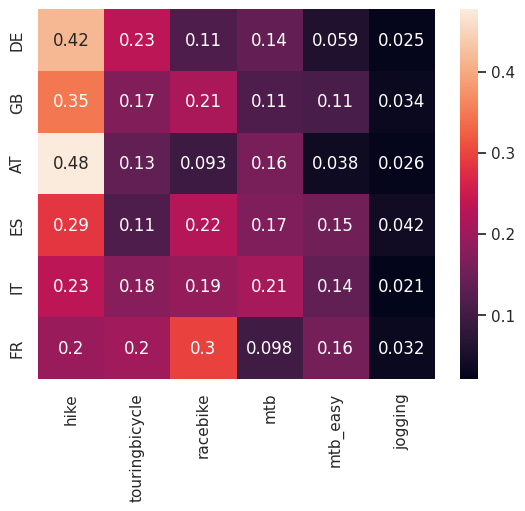

In [220]:
import seaborn as sns

p1 = sns.heatmap(df_sport_paesi, annot = True)

## Correlazione tra centralità e paese

Komoot è una piattaforma tedesca. Vediamo se questa caratteristica si ripercuote anche sulla nazionalità degli utenti più centrali. Usiamo la **indegree centrality**.

In [269]:
from scipy import stats

degree_centrality = nx.degree_centrality(g)
attributi_country = nx.get_node_attributes(g, "country")
corr = dict()

countries = list()
for country in countries_list:
    countries.append(country[0])

for country in countries:
    centralita = []  # Lista per memorizzare la centralità dei nodi
    attributi_categorici = []  # Lista per memorizzare gli attributi "country"

    for nodo in g.nodes():
        centralita.append(degree_centrality[nodo])
        if attributi_country[nodo] == country:
            attributi_categorici.append(1)
        else:
            attributi_categorici.append(0)

    correlazione, p_value = stats.pointbiserialr(attributi_categorici, centralita)
    corr[country] = correlazione

corr

{'DE': 0.05616833506631623,
 'Unknown': -0.08339537540690938,
 'GB': -0.022450638752183612,
 'IT': 0.01619317990090649,
 'ES': 0.005620247106776544,
 'AT': 0.017380859870287507,
 'FR': -0.002961715130053248,
 'NL': 0.009474312248664976,
 'CH': 0.0009382159150547233,
 'BE': -0.0037853844830806537,
 'US': 0.0023059762865948563,
 'PT': -0.0025573072452313053,
 'CZ': 0.0048880425817536,
 'PL': -0.005880877489233564,
 'DK': 0.008536301499035072,
 'SE': -0.0015156932346385825,
 'NO': -0.003793091975565678,
 'IE': 0.0008980864547034786,
 'SI': -0.0036868225445803814,
 'GR': 0.00975818515871155,
 'HR': 0.006838804851199414,
 'CA': 0.0015986278998108433,
 'RO': -0.002986501983922974,
 'MA': 0.004588703717521319,
 'AU': -0.003396019641289646,
 'FI': -0.0016247429132968585,
 'MX': 0.0009113600447267725,
 'HU': -0.0012860028795400433,
 'ID': -0.002903806436734692,
 'CO': -0.002955750799654988,
 'LU': 0.0009626355154236905,
 'ZA': 0.005352595687274664,
 'TR': 0.001484159532565824,
 'IN': 0.00739429

In [281]:
for key in sorted(corr.items(), key=lambda item: item[1])[:10]:
    print(f'{key[0]} {corr[key[0]]}')

Unknown -0.08339537540690938
GB -0.022450638752183612
PL -0.005880877489233564
NO -0.003793091975565678
BE -0.0037853844830806537
SI -0.0036868225445803814
AU -0.003396019641289646
RO -0.002986501983922974
FR -0.002961715130053248
CO -0.002955750799654988


In [285]:
for key in sorted(corr.items(), key=lambda item: item[1])[-10:]:
    print(f'{key[0]} {corr[key[0]]}')

DK 0.008536301499035072
NL 0.009474312248664976
GR 0.00975818515871155
LT 0.012551048544088245
IT 0.01619317990090649
AT 0.017380859870287507
CI 0.01771793300812588
KE 0.032133859009221666
MK 0.03259318264382647
DE 0.05616833506631623


## Correlazione tra centralità e km percorsi

È plausibile che i nodi con più km percorsi siano anche quelli più centrali. Questo in quanto non si tratta dei km percorsi totali (cioè quelli che si registrano usando l'app) ma di quelli pubblicati. Questa differenza è importante in quanto ci stiamo chiedendo se chi pubblica di più è più centrale.

In [287]:
degree_centrality = nx.degree_centrality(g)
attributi = nx.get_node_attributes(g, "km")
corr_km = dict()

centralita = []  # Lista per memorizzare la centralità dei nodi
km = []  # Lista per memorizzare gli attributi "km"

for nodo in g.nodes():
    centralita.append(degree_centrality[nodo])
    km.append(attributi[nodo])

correlazione, p_value = stats.pearsonr(km, centralita)
correlazione

0.18339990721995728

## Assortatività

Calcoliamo l'assortatività sull'attributo "country"

In [289]:
nx.attribute_assortativity_coefficient(g,attribute="country")

0.39281956301023974

È abbastanza alta! Calcoliamola anche sul numero di KM percorsi

In [291]:
nx.numeric_assortativity_coefficient(g,attribute="km")

0.01779364899031746

In questo caso invece non si nota una grande assortatività. Infine calcoliamolo anche sul tipo di sport

In [292]:
nx.attribute_assortativity_coefficient(g,attribute="sport")

0.19533193151889125

Non è nulla ma comunque rilevante. Infine calcoliamo la degree assortativity.

In [293]:
nx.degree_assortativity_coefficient(g)

-0.09857265054679418

# Analisi della rete italiana
![](gephi/komoot-italy.png)

Vediamo alcune delle misure più interessanti sulla rete italiana

In [10]:
g = nx.read_graphml("graphs/komoot-network-100000-attributes.graphml")

In [11]:
nodes_it = (node for node, data in g.nodes(data=True) if data.get("country") == "IT")
g = g.subgraph(nodes_it)

In [12]:
print(f"Numero di nodi: {g.order()}\nNumero di archi: {g.size()}")
print(g)

Numero di nodi: 4286
Numero di archi: 35676
DiGraph with 4286 nodes and 35676 edges


In [13]:
print(f'Density: {nx.density(g)}')

Density: 0.0019425542770116376


In [14]:
degree_list =list(dict(g.in_degree()).values())
print(f'Grado medio: {np.mean(degree_list)}')
print(f'Standard deviation: {np.std(degree_list)}')
print(f'Median: {np.median(degree_list)}')
print(f'Min: {np.min(degree_list)}')
print(f'Max: {np.max(degree_list)}')

Grado medio: 8.323845076994868
Standard deviation: 29.74757115309467
Median: 2.0
Min: 0
Max: 543


In [15]:
#InDegree Centrality
degree=dict(g.in_degree())
degree_centrality = {n: round(c/(g.order()-1),4) for n,c in degree.items()}
node_d_centr = list(degree_centrality.items())
node_d_centr.sort(key = lambda x: x[1], reverse = True)
node_d_centr[:5]

[('691888089690', 0.1267),
 ('gravelclubit', 0.1116),
 ('742977103995', 0.1099),
 ('529530185629', 0.106),
 ('330965983608', 0.0922)]

In [16]:
#Closeness centrality
closeness_centrality = nx.closeness_centrality(g)
node_c_centr = list(closeness_centrality.items())
node_c_centr.sort(key = lambda x: x[1], reverse = True)
node_c_centr[:5]

[('691888089690', 0.3405729320717798),
 ('komoot', 0.32392550699104244),
 ('742977103995', 0.3178208542078736),
 ('529530185629', 0.317202445489088),
 ('330965983608', 0.31548363466331814)]

In [17]:
#Betweeness centrality
betweenness_centrality=nx.betweenness_centrality(g)
node_b_centr = list(betweenness_centrality.items())
node_b_centr.sort(key = lambda x: x[1], reverse = True)
node_b_centr[:5]

[('2207069696217', 0.10263621497426892),
 ('774422835486', 0.06197633981852662),
 ('812293853181', 0.03885506856187293),
 ('919246440735', 0.038411987216741786),
 ('1755113940914', 0.03764075090988107)]

In [18]:
#Eigenvector cenrality
eigenvector_centrality = nx.eigenvector_centrality(g,200)
node_e_centr = list(eigenvector_centrality.items())
node_e_centr.sort(key = lambda x: x[1], reverse = True)
node_e_centr[:5]

[('529530185629', 0.22475894086386106),
 ('330965983608', 0.21569511876053496),
 ('995149512812', 0.19305409952602423),
 ('691888089690', 0.1912784970428975),
 ('gravelclubit', 0.18368965508254595)]

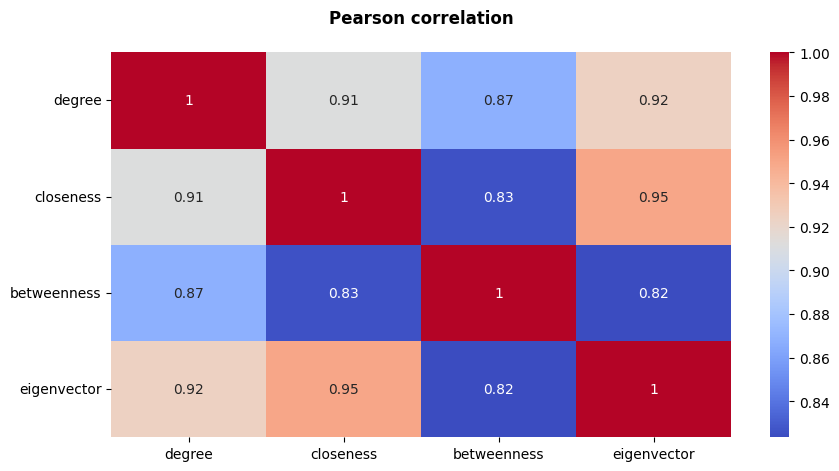

In [21]:
import scipy
import seaborn as sns

all_centr = [degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality]
ranks = [[scipy.stats.weightedtau(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(ranks),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()

## Link prediction

Importiamo le due reti. Sono reti ottenute in due istanti temporali diversi, a distanza di circa due settimane una dall'altra.

In [89]:
# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
past = nx.read_graphml("graphs/komoot-network-100000-attributes.graphml")
past.order(), past.size()

(74139, 1113417)

In [40]:
future = nx.read_graphml("graphs/komoot-network-100000-future-wo-leafs.graphml")
future.order(), future.size()

(77724, 1169237)

Ora troviamo tutti quegli edge che sono presenti nella rete più recente ma non in quella passata. Nel fare questo dobbiamo stare attenti a selezionare solo quei link che si sono creati tra coppie di nodi già presenti nella rete passata.

In [44]:
positive_datapoints = np.array([{u,v} for u,v in future.edges() if not past.has_edge(u, v) and past.has_node(u) and past.has_node(v)])

In [49]:
positive_datapoints = [(u,v) for u, v in positive_datapoints]

In [50]:
len(positive_datapoints)

9845

Ora selezioniamo un numero uguale di link che invece non si sono formati.

In [46]:
negative_datapoints = []
nodes_set = list(future.nodes())
count = 0
while count < len(positive_datapoints):
    u,v = np.random.choice(nodes_set, replace=False, size = 2)
    if (not future.has_edge(u,v)) and past.has_node(u) and past.has_node(v):
        negative_datapoints.append((u,v))
        count+=1 

In [47]:
len(negative_datapoints)

9845

Creiamo il nostro dataset con tutte le feature e le label corrette

In [51]:
dataset_link_prediction = pd.DataFrame()

In [52]:
datapoints = positive_datapoints + negative_datapoints # insieme degli oggetti di cui necessito calcolare delle proprietà

In [53]:
datapoints[:10]

[('385673470997', 'betty'),
 ('hohetauern', 'betty'),
 ('ferienregionnationalparkbayerischerwald', 'betty'),
 ('774010743877', '1898789994798'),
 ('774010743877', '774422835486'),
 ('774010743877', '2609581051379'),
 ('774010743877', '999599803959'),
 ('774010743877', '1392086450114'),
 ('774010743877', 'myswitzerland'),
 ('774010743877', '532193254039')]

In [58]:
dataset_link_prediction['jaccard'] = [j for _,_,j in nx.jaccard_coefficient(past.to_undirected(), datapoints)]

In [59]:
dataset_link_prediction['rai'] = [j for _,_,j in nx.resource_allocation_index(past.to_undirected(), datapoints)]

In [60]:
dataset_link_prediction['aai'] = [j for _,_,j in nx.adamic_adar_index(past.to_undirected(), datapoints)]

In [61]:
dataset_link_prediction['pref'] = [j for _,_,j in nx.preferential_attachment(past.to_undirected(), datapoints)]

In [69]:
dataset_link_prediction['same_country'] = [1 if past.nodes[u]["country"] == past.nodes[v]["country"] else 0 for u, v in datapoints]

In [71]:
dataset_link_prediction['same_sport'] = [1 if past.nodes[u]["sport"] == past.nodes[v]["sport"] else 0 for u, v in datapoints]

In [77]:
dataset_link_prediction['km_diff'] = [abs(past.nodes[u]["km"] - past.nodes[v]["km"]) for u, v in datapoints]

In [78]:
dataset_link_prediction

,jaccard,rai,aai,pref,same_country,same_sport,km_diff
0,0.081478,1.477435,37.086708,1489146,0,0,18084
1,0.002232,0.004735,0.313497,18417,1,0,18084
2,0.006601,0.090585,1.345760,33326,0,0,18084
3,0.005698,0.110235,1.265011,119168,0,0,16392
4,0.049121,0.288593,13.336372,743869,0,0,4861
...,...,...,...,...,...,...,...
19685,0.000000,0.000000,0.000000,39,0,0,1272
19686,0.000000,0.000000,0.000000,16,1,0,7
19687,0.000000,0.000000,0.000000,12,0,0,3466
19688,0.000000,0.000000,0.000000,5,0,0,0


Ora aggiungiamo le etichette

In [79]:
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]

In [80]:
dataset_link_prediction

,jaccard,rai,aai,pref,same_country,same_sport,km_diff,label
0,0.081478,1.477435,37.086708,1489146,0,0,18084,1
1,0.002232,0.004735,0.313497,18417,1,0,18084,1
2,0.006601,0.090585,1.345760,33326,0,0,18084,1
3,0.005698,0.110235,1.265011,119168,0,0,16392,1
4,0.049121,0.288593,13.336372,743869,0,0,4861,1
...,...,...,...,...,...,...,...,...
19685,0.000000,0.000000,0.000000,39,0,0,1272,0
19686,0.000000,0.000000,0.000000,16,1,0,7,0
19687,0.000000,0.000000,0.000000,12,0,0,3466,0
19688,0.000000,0.000000,0.000000,5,0,0,0,0


Ora che abbiamo il dataset possiamo dividerlo nella feature matrix e nelle label. Inoltre dobbiamo dividerlo nel dataset di training e in quello di test.

In [81]:
X = dataset_link_prediction[['jaccard','rai','aai','pref','same_country','same_sport','km_diff']] #feature matrix
y = dataset_link_prediction['label'] # label

In [82]:
X.shape, y.shape

((19690, 7), (19690,))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [87]:
X_train.shape

(13783, 7)

Alcuni algoritmi di apprendimento non gestiscono correttamente feature che hanno range di variazione differenti tra loro. Per questo motivo e' sempre consigliato eseguire uno scaling, in modo da riportare tutte le feature in un range di variazione ridotto. Solitamente i range più utilizzati sono [0,1] oppure centrati attorno allo zero mediante standardizzazione.

In questo caso riportiamo tutte le feature nel range [0,1] mediante min-max scaling.

In [91]:
ct = ColumnTransformer([
    ('minmax',MinMaxScaler(),['jaccard','rai','aai','pref', 'km_diff'])
]
)

Possiamo ora applicare un algoritmo di apprendimento classico per problemi di classificazione binaria: Logistic Regression. L'algoritmo viene implementato in SKL dalla classe LogisticRegression del modulo linear_model.

In SKL tutti i classificatori fanno parte della famiglia dei Predictor, ossia oggetti che implementano i metodi fit e predict. Mediante il primo metodo, il predictor impara la funzione - nel caso di log reg vengono aggiornati i pesi - mentre il secondo metodo assegna le etichette a nuovi oggetti, secondo la funzione imparata durante la fase di fit.

In [95]:
link_predictor = Pipeline([
    ('preprocessing',ct),
    ('classifier',LogisticRegression(penalty=None))
]
)

In [96]:
link_predictor.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['jaccard', 'rai', 'aai',
                                                   'pref', 'km_diff'])])),
                ('classifier', LogisticRegression(penalty=None))])

In [97]:
y_predicted = link_predictor.predict(X_test)

Ora stampiamo un paio di statistiche

In [98]:
accuracy_score(y_test, y_predicted)

0.8894531911291688

In [99]:
f1_score(y_test, y_predicted), recall_score(y_test, y_predicted), precision_score(y_test, y_predicted)

(0.8805997440117024, 0.8094117647058824, 0.9655172413793104)

Ma soprattutto la confusion matrix!

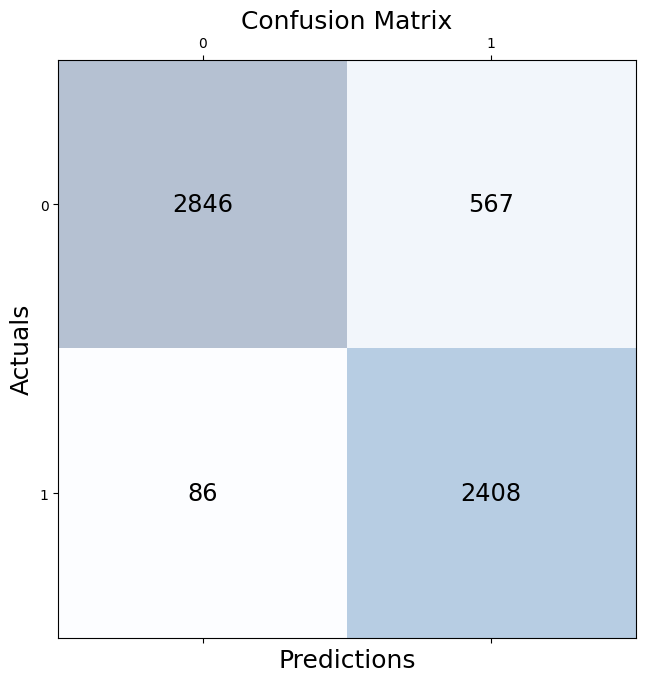

In [101]:
conf_matrix = confusion_matrix(y_predicted, y_test)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Ora ci riproviamo usando Random Forest

In [102]:
link_predictor_rf = Pipeline([
    ('preprocessing',ct),
    ('classifier',RandomForestClassifier(n_estimators=100, 
        max_features=3, max_leaf_nodes=8, n_jobs=-1)
    )
]
)

In [103]:
link_predictor_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['jaccard', 'rai', 'aai',
                                                   'pref', 'km_diff'])])),
                ('classifier',
                 RandomForestClassifier(max_features=3, max_leaf_nodes=8,
                                        n_jobs=-1))])

In [105]:
named_feat_importance = dict(zip(['jaccard','rai','aai','pref', 'same_country', 'same_sport', 'km_diff'], link_predictor_rf['classifier'].feature_importances_))
sorted(named_feat_importance.items(), key=lambda x:x[1], reverse=True)

[('rai', 0.48554662908337937),
 ('aai', 0.32167940797248895),
 ('pref', 0.17872985231210872),
 ('jaccard', 0.012160258540252523),
 ('same_country', 0.0018838520917704906)]

In [106]:
y_predicted = link_predictor_rf.predict(X_test)

Stampiamo un paio di statistiche anche in questo caso

In [107]:
accuracy_score(y_test, y_predicted)

0.9250042322668021

In [108]:
f1_score(y_test, y_predicted), recall_score(y_test, y_predicted), precision_score(y_test, y_predicted)

(0.9258577405857741, 0.9297478991596638, 0.922)

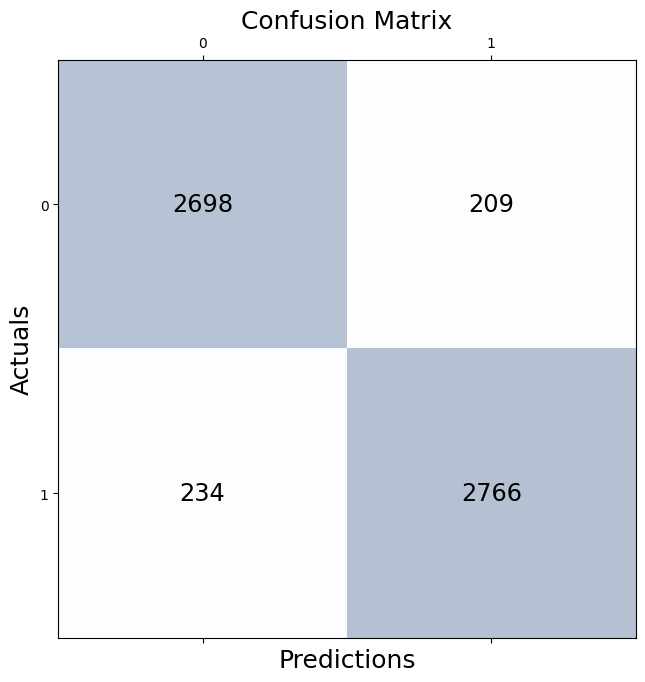

In [109]:
conf_matrix = confusion_matrix(y_predicted, y_test)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

FINE!